# Natural Language Processing

## Part 5: TorchText + Padded + BiLSTM + Attention


Here we shall explore three kinds of attention in this tutorial - (1) general attention, (2) self attention, and (3) multi-headed self-attention.  

Feel free to just skip to the model part because it's the only part changing from Part 3.

In [1]:
import torch, torchdata, torchtext
from torch import nn
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import AG_NEWS
train, test = AG_NEWS()

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
next(iter(train))

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [8]:
#let's change the unique label
set([y for y, x in list(iter(train))])
#{“World”, “Sports”, “Business”, “Sci/Tech”}

{1, 2, 3, 4}

In [9]:
train_size = len(list(iter(train)))
train_size

120000

Since 120000 gonna just take up too much of our GPU, and also for the sake of learning, we gonna resize it.....  All `DataPipe` instance has a handy function called `random_split`

In [10]:
too_much, train, valid = train.random_split(total_length=train_size, weights = {"too_much": 0.7, "smaller_train": 0.2, "valid": 0.1}, seed=999)

In [11]:
train_size = len(list(iter(train)))
train_size

24000

In [12]:
val_size = len(list(iter(valid)))
val_size

12000

In [13]:
test_size = len(list(iter(test)))
test_size

7600

## 3. Preprocessing 

### Tokenizing

The first step is to decide which tokenizer we want to use, which depicts how we split our sentences.

In [14]:
#pip install spacy
#python3 -m spacy download en_core_web_sm
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
tokens = tokenizer("We are learning torchtext in AIT!")  #some test
tokens

['We', 'are', 'learning', 'torchtext', 'in', 'AIT', '!']

### Text to integers (numeral)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [15]:
from torchtext.vocab import build_vocab_from_iterator
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>', '<bos>', '<eos>'])
vocab.set_default_index(vocab["<unk>"])

In [16]:
#see some example
vocab(['here', 'is', 'a', 'unknownword', 'a'])

[509, 27, 9, 0, 9]

In [17]:
#we can reverse it....
mapping = vocab.get_itos()

#print 159, for example
mapping[509]

'here'

In [18]:
#let's try unknown vocab
vocab(['dddd', 'aaaa'])
#they will all map to <unk> which has 0 as integer

[0, 0]

In [19]:
#let's try special symbols
vocab(['<pad>', '<bos>', '<eos>'])

[1, 2, 3]

In [20]:
#so we can 50k+ unique vocabularies!
len(vocab)

52828

## 4. FastText Embeddings

In [21]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple') #small for easy training

In [22]:
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
# vocab.get_itos() returns a list of strings (tokens), where the token at the i'th position is what you get from doing vocab[token]
# get_vecs_by_tokens gets the pre-trained vector for each string when given a list of strings
# therefore pretrained_embedding is a fully "aligned" embedding matrix

In [23]:
fast_embedding.shape   #we have X vocabs, each with a 300 fasttext embedding

torch.Size([52828, 300])

## 5. Preparing the dataloader

In torchtext, first thing before the batch iterator is to define how you want to process your text and label.  

In [24]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1 #turn {1, 2, 3, 4} to {0, 1, 2, 3} for pytorch training 

Let's look at example how it looks

In [25]:
text_pipeline("I love to play football")

[275, 4021, 8, 389, 574]

In [26]:
label_pipeline('1')

0

Next, let's make the batch iterator.  Here we create a function <code>collate_fn</code> that define how we want to create our batch.  **We gonna add length of the sequence since packed padded sequences require this.**

In [27]:
from torch.utils.data   import DataLoader
from torch.nn.utils.rnn import pad_sequence

pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0))  #++<-----packed padded sequences require 
    #criterion expects float labels
    return torch.tensor(label_list, dtype=torch.int64), pad_sequence(text_list,  padding_value=pad_idx, batch_first=True), torch.tensor(length_list, dtype=torch.int64)

Create train, val, and test dataloaders

In [28]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.  Note that {“World”, “Sports”, “Business”, “Sci/Tech”} maps to {0, 1, 2, 3}

In [29]:
for label, text, length in train_loader:
    break

In [30]:
print("Label shape: ", label.shape) # (batch_size, )
print("Text shape: ", text.shape)   # (batch_size, seq len)

Label shape:  torch.Size([64])
Text shape:  torch.Size([64, 138])


## 6. Design the model

Here we shall implement three types of attention:

1. **General-attention** refers to the attention between output from LSTM (all hidden states) and the last hidden state.
2. **Self-attention** refersto the self-attention between output from LSTM (all hidden states) and themselves.  That is, pairwise.
3. **Multi-head attention** divides the input into several smaller parts and feed into the attention net parallely, speedying up the training process.

### Defining hyperparameters

In [31]:
input_dim = len(vocab)
hidden_dim = 256
embed_dim  = 300       
output_dim = 4 #four classes

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

#training hyperparameters
num_epochs=1
lr=1e-3

In [32]:
import torch.nn as nn
from torch.nn import functional as F

class generalAttention(nn.Module):
    def __init__(self):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    #https://arxiv.org/pdf/1409.0473.pdf
    # lstm_output : [batch_size, seq len, n_hidden * num_directions(=2)]
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.unsqueeze(2)  # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) # attn_weights : [batch_size, seq_len, 1]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), seq_len] * [batch_size, seq_len, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.cpu().data.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        attn_output, attention = self.attention_net(output, hn)
        return self.fc(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

In [33]:
import torch.nn as nn

#this attention mask will be apply after Q @ K^T thus the shape will be batch, seq_len, seq_len
def get_pad_mask(text):  #[batch, seq_len]
    batch_size, seq_len = text.size()
    # eq(zero) is lstm output over PAD token
    pad_mask = text.data.eq(0).unsqueeze(1)  # batch_size x 1 x seq_len; we unsqueeze so we can make expansion below
    return pad_mask.expand(batch_size, seq_len, seq_len)  # batch_size x seq_len x seq_len

class selfAttention(nn.Module):
    def __init__(self, len_reduction='mean'):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax       = nn.LogSoftmax(dim=1)
        self.len_reduction = len_reduction
        self.lin_Q = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_K = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_V = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        
    # lstm_output : [batch_size, seq len, n_hidden * num_directions(=2)]
    def self_attention_net(self, lstm_output, pad_mask):
        q = self.lin_Q(torch.clone(lstm_output))
        k = self.lin_K(torch.clone(lstm_output))
        v = self.lin_V(torch.clone(lstm_output))
        # q : [batch_size, seq_len, n_hidden * num_directions(=2)]
        # k.transpose(1, 2): [batch_size, n_hidden * num_directions(=2), seq_len]
        # attn_w = [batch_size, seq_len, seq_len]
                
        attn_w = torch.matmul(q, k.transpose(1, 2))
                
        #apply padding mask 
        if self.mask:
            attn_w.masked_fill_(pad_mask, -1e9) # Fills elements of self tensor with value where mask is one.

        sfmx_attn_w = self.softmax(attn_w)
        # context = [batch_size, seq_len, hidden_dim * num_directions(=2)]
        context = torch.matmul(sfmx_attn_w, v)
        if self.len_reduction == "mean":
            return torch.mean(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "sum":
            return torch.sum(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "last":
            return context[:, -1, :], sfmx_attn_w.cpu().data.numpy()
        
    def forward(self, text, text_lengths, mask=True):
        
        self.mask = mask
        pad_mask = get_pad_mask(text)
        
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
                
        attn_output, attention  = self.self_attention_net(output, pad_mask)
                
        #attn_output = [batch_size, hidden_dim * num_direction(=2)]
        return self.fc(attn_output), attention

In [34]:
import torch.nn as nn

n_heads = 8
d_k = (hidden_dim * 2) // n_heads # (256 * 2) // 8

#this attention mask will be apply after Q @ K^T thus the shape will be batch, seq_len, seq_len
def get_pad_mask(text):  #[batch, seq_len]
    batch_size, seq_len = text.size()
    # eq(zero) is lstm output over PAD token
    pad_mask = text.data.eq(0).unsqueeze(1)  # batch_size x 1 x seq_len; we unsqueeze so we can make expansion below
    return pad_mask.expand(batch_size, seq_len, seq_len)  # batch_size x seq_len x seq_len

class multiheadAttention(nn.Module):
    def __init__(self, len_reduction='mean'):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax       = nn.LogSoftmax(dim=1)
        self.len_reduction = len_reduction
        self.lin_Q = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_K = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.lin_V = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        
    # lstm_output : [batch_size, seq len, n_hidden * num_directions(=2)]
    def multi_headed_self_attention_net(self, lstm_output, pad_mask):           
        residual, batch_size = lstm_output, lstm_output.size(0) #<---residual added to the last output; batch_size may not be even for the last unit
        
        q = self.lin_Q(torch.clone(lstm_output))
        k = self.lin_K(torch.clone(lstm_output))
        v = self.lin_V(torch.clone(lstm_output))
        # q : [batch_size, seq_len, n_hidden * num_directions(=2)]
        # k.transpose(1, 2): [batch_size, n_hidden * num_directions(=2), seq_len]
        # attn_w = [batch_size, seq_len, seq_len]
        
        #split into heads
        q = q.view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q: [batch_size x n_heads x seq_len x d_k]
        k = k.view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k: [batch_size x n_heads x seq_len x d_k]
        v = v.view(batch_size, -1, n_heads, d_k).transpose(1,2)  # v: [batch_size x n_heads x seq_len x d_k]
        
        # repeat the attention mask n_heads time
        pad_mask = pad_mask.unsqueeze(1).repeat(1, n_heads, 1, 1) # pad_mask : [batch_size x n_heads x seq_len x seq_len]
        
        # dot production attention
        attn_w = torch.matmul(q, k.transpose(-1, -2)) / np.sqrt(d_k) # [batch_size x n_heads x seq_len x seq_len]
                
        if self.mask:
            attn_w.masked_fill_(pad_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        sfmx_attn_w = self.softmax(attn_w)
        context = torch.matmul(sfmx_attn_w, v) # [batch_size x n_heads x seq_len x d_k]
        
        # concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_k) # context: [batch_size x seq_len x n_heads * d_k]
        # now context: [batch_size, seq_len, hidden_dim * 2]
        
        # doing skip connection
        # https://stats.stackexchange.com/questions/474440/why-do-transformers-use-layer-norm-instead-of-batch-norm
        context = self.layer_norm(residual + context)

        if self.len_reduction == "mean":
            return torch.mean(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "sum":
            return torch.sum(context, dim=1), sfmx_attn_w.cpu().data.numpy()
        elif self.len_reduction == "last":
            return context[:, -1, :], sfmx_attn_w.cpu().data.numpy()
        
    def forward(self, text, text_lengths, mask=True):
        self.mask = mask
        pad_mask = get_pad_mask(text)  # batch_size x seq_len x seq_len
        
        #text = [batch size, seq len]
        embedded = self.embedding(text)

        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
                
        attn_output, attention  = self.multi_headed_self_attention_net(output, pad_mask)        
        #attn_output = [batch_size, hidden_dim * num_direction(=2)]
        
        return self.fc(attn_output), attention

In [35]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [36]:
model1 = generalAttention().to(device)
model1.apply(initialize_weights)
model1.embedding.weight.data = fast_embedding

In [37]:
model2 = selfAttention().to(device)
model2.apply(initialize_weights)
model2.embedding.weight.data = fast_embedding

In [38]:
model3 = multiheadAttention().to(device)
model3.apply(initialize_weights)
model3.embedding.weight.data = fast_embedding

In [39]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model1), count_parameters(model2), count_parameters(model3)

15848400
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2048
     4
______
18570196
15848400
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2048
     4
262144
   512
262144
   512
262144
   512
______
19358164
15848400
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2048
     4
262144
   512
262144
   512
262144
   512
   512
   512
______
19359188


(None, None, None)

## 7. Training

In [40]:
#specify here
model = model3

In [41]:
import torch.optim as optim

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [42]:
def accuracy(preds, y):
    
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [43]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions, attention = model(text, text_length)
        predictions = predictions.squeeze(1)  #output by the fc is (batch_size, 1), thus need to remove this 1
        
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [44]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions, attention = model(text, text_length)
            predictions = predictions.squeeze(1)
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

### Putting everything together

In [45]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [46]:
best_valid_loss = float('inf')

save_path = f'models/{model.__class__.__name__}'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.710 | Train Acc: 76.17%
	 Val. Loss: 0.294 |  Val. Acc: 91.09%


Text(0, 0.5, 'loss')

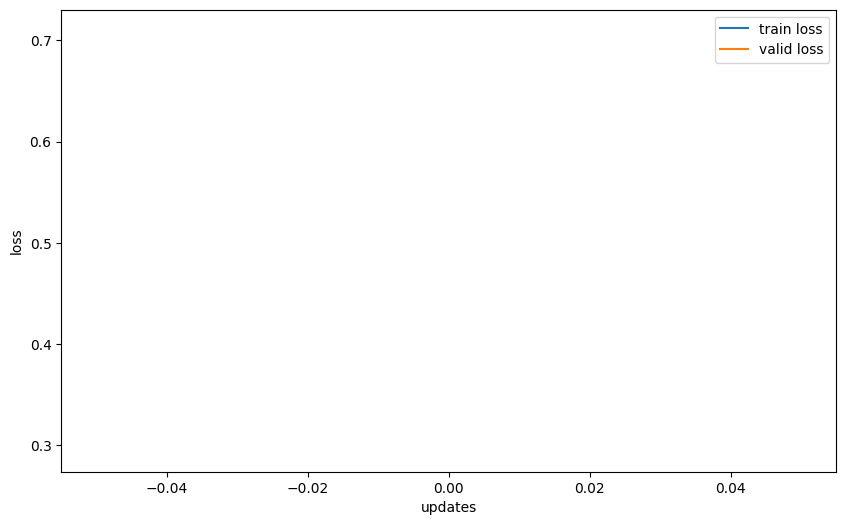

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

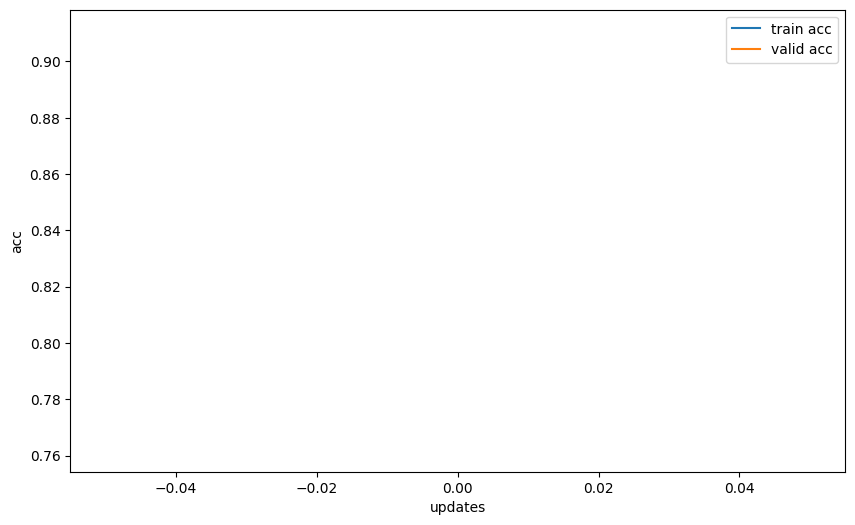

In [48]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [49]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.323 | Test Acc: 90.00%


## 8. Test on some random news

In [50]:
test_str = "Google is now falling nonstop.  The price is really bad now."
text = torch.tensor(text_pipeline(test_str)).to(device)
text

tensor([  190,    27,   231,  1742, 14918,     6,    16,    21,   358,    27,
         2561,  1316,   231,     6], device='cuda:0')

In [51]:
text_list = [x.item() for x in text]
text_list

[190, 27, 231, 1742, 14918, 6, 16, 21, 358, 27, 2561, 1316, 231, 6]

In [52]:
[mapping[num] for num in text_list]

['Google',
 'is',
 'now',
 'falling',
 'nonstop',
 '.',
 ' ',
 'The',
 'price',
 'is',
 'really',
 'bad',
 'now',
 '.']

In [53]:
text = text.reshape(1, -1)  #because batch_size is 1

In [54]:
text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)

In [55]:
text.shape

torch.Size([1, 14])

In [56]:
def predict(text, text_length):
    with torch.no_grad():
        output, attention = model(text, text_length)
        output = output.squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [57]:
predict(text, text_length)

tensor([2], device='cuda:0')

## Conclusion

In general, LSTM with attention provides strong flexibility for the network to adjust the weights more creatively, especially among the hidden states, thus generally better than vanilla LSTM.  As for which variant, there are no clear conclusion yet, since different models simply allows more flexibility for the model to learn in different ways, thus researchers are not so interested to compare different variants.